# **Image Caption Generator with CNN & LSTM**

The objective of our project is to learn the concepts of a CNN and LSTM model and build a working model of Image caption generator by implementing CNN with LSTM.

In this Python project, we will be implementing the caption generator using CNN (Convolutional Neural Networks) and LSTM (Long short term memory). The image features will be extracted from Xception which is a CNN model trained on the imagenet dataset and then we feed the features into the LSTM model which will be responsible for generating the image captions.

## Import Modules


In [ ]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
from tensorflow.keras.applications.vgg16 import VGG16 , preprocess_input
from tensorflow.keras.preprocessing.image import load_img , img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input , Dense , LSTM , Embedding , Dropout , add

In [ ]:
# mounting Load Google drive to Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
BASE_DIR = '/content/drive/MyDrive/ColabNotebooks/ImageCaption/archive'
WORKING_DIR = '/content/drive/MyDrive/ColabNotebooks/ImageCaption/archive'

## CNN Model for Feature Extraction

his block describes how a pre-trained CNN (like VGG16 or ResNet) is used to extract features from images. The CNN model is typically pre-trained on a large dataset like ImageNet and fine-tuned for the specific task.

In [ ]:
# Load vgg16 Model
model = VGG16()

# restructure model
model = Model(inputs = model.inputs , outputs = model.layers[-2].output)

# Summerize
print(model.summary())

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

# **Extracting Features from Images**

Description: This block of code is responsible for extracting features from images using a pre-trained model. It loads each image from a specified directory, preprocesses the image to the required input format, and uses the pre-trained model to generate feature vectors for each image. These features are then stored in a dictionary with the image ID as the key.

In [ ]:
# extract features from image
features = {}
directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

100%|██████████| 8094/8094 [14:55<00:00,  9.04it/s]


pickle is used to save the extracted image features to a file. This is useful because it allows us to save the preprocessed data and quickly load it in the future without having to reprocess the images every time, saving time and computational resources.

In [ ]:
# store features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [ ]:
# load features from pickle
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

## Load the Captions Data

In [ ]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

### Split and append the captions data with the image

In [ ]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

100%|██████████| 40456/40456 [00:00<00:00, 647943.59it/s]


In [ ]:
# no. of images loaded
len(mapping)

8091

## Preprocess Text Data

In [ ]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc.,
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

Visualize the text before and after cleaning

In [ ]:
# before preprocess of text
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [ ]:
# preprocess the text
clean(mapping)

In [ ]:
# after preprocess of text
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

Store the preprocessed captions into a list

In [ ]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [ ]:
len(all_captions)

40455

In [ ]:
# first ten captions
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

## Processing of Text Data

This block of code tokenizes the text captions. It creates a Tokenizer object from the Keras library, which is used to vectorize a text corpus by turning each text into either a sequence of integers or a vector. The tokenizer is then fitted on all the captions, which builds the word index based on the frequency of words in the captions.



In [ ]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
# No. of unique words
vocab_size

8485

In [ ]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

## Train Test Split

splits the dataset into training and testing sets

In [ ]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [ ]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq],num_classes=vocab_size)[0]
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

## Model Creation

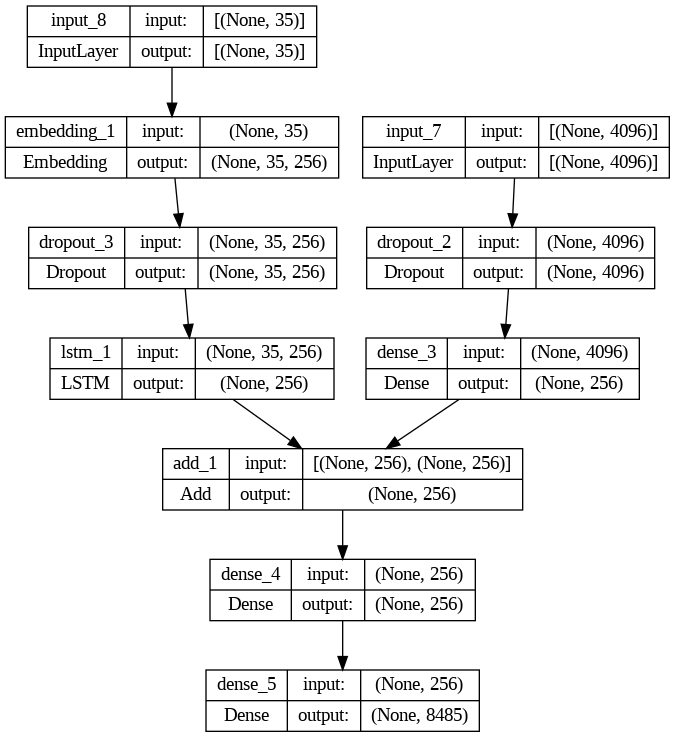

In [ ]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

## Train the Model

This block involves training the model on the prepared dataset. It includes specifying the loss function, optimizer, and running the training loop.



In [ ]:
# train the model
epochs = 10
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

227/227 [==============================] - 59s 260ms/step - loss: 2.6106


### Save the model in the working directory for reuse

In [ ]:
# save the model
model.save(WORKING_DIR+'/best_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from keras.models import load_model

# Path to the saved model
model_path = WORKING_DIR + '/best_model.h5'

# Load the model
loaded_model = load_model(model_path)

## Generate Captions for the Image

In [ ]:
# Convert the predicted index from the model into a word
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [ ]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'caption: "'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == '"':
            break
    return in_text

## Model Validation

In [ ]:
# validate the data using BLEU Score
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

100%|██████████| 810/810 [37:20<00:00,  2.77s/it]


BLEU-1: 0.108642
BLEU-2: 0.058483


## Visualize the Results

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq black dog and spotted dog are fighting endseq
startseq black dog and tri-colored dog playing with each other on the road endseq
startseq black dog and white dog with brown spots are staring at each other in the street endseq
startseq two dogs of different breeds looking at each other on the road endseq
startseq two dogs on pavement moving toward each other endseq
--------------------Predicted--------------------
caption: " two dogs playing with each other endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq


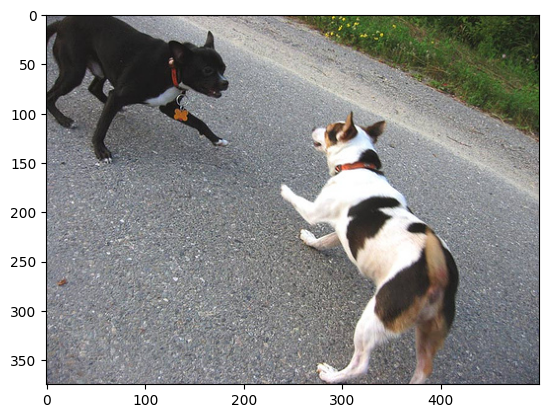

In [ ]:
generate_caption("1001773457_577c3a7d70.jpg")

---------------------Actual---------------------
startseq couple stands close at the water 's edge endseq
startseq the two people stand by body of water and in front of bushes in fall endseq
startseq two people hold each other near pond endseq
startseq two people stand by the water endseq
startseq two people stand together on the edge of the water on the grass endseq
--------------------Predicted--------------------
caption: " two couple are on the edge of lake endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq


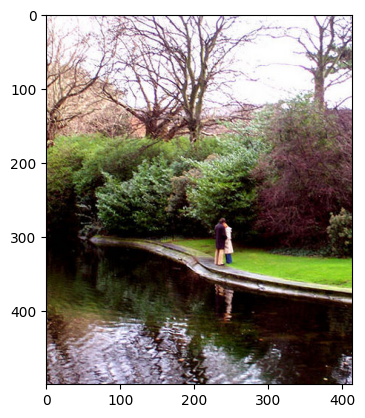

In [ ]:
generate_caption("3637013_c675de7705.jpg")

---------------------Actual---------------------
startseq blonde horse and blonde girl in black sweatshirt are staring at fire in barrel endseq
startseq girl and her horse stand by fire endseq
startseq girl holding horse 's lead behind fire endseq
startseq "a man and girl and two horses are near contained fire ." endseq
startseq two people and two horses watching fire endseq
--------------------Predicted--------------------
caption: " horse horse at contained fire endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq


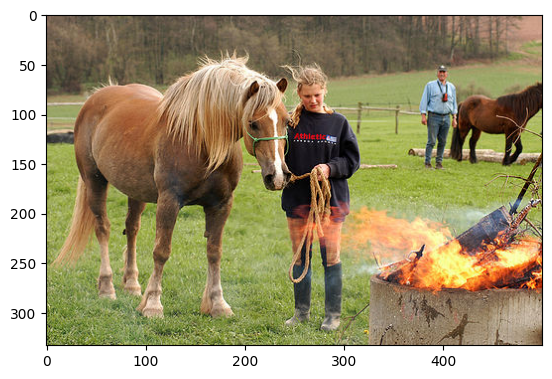

In [ ]:
generate_caption("10815824_2997e03d76.jpg")

---------------------Actual---------------------
startseq man in red jacket is sitting on bench whilst cooking meal endseq
startseq "a man is sitting on bench cooking some food ." endseq
startseq man sits on bench endseq
startseq man wearing red jacket is sitting on wooden bench and is cooking something in small pot endseq
startseq man wearing red jacket sitting on bench next to various camping items endseq
--------------------Predicted--------------------
caption: " mountain man wearing blue shirt and jeans is riding on the side of the woods endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq


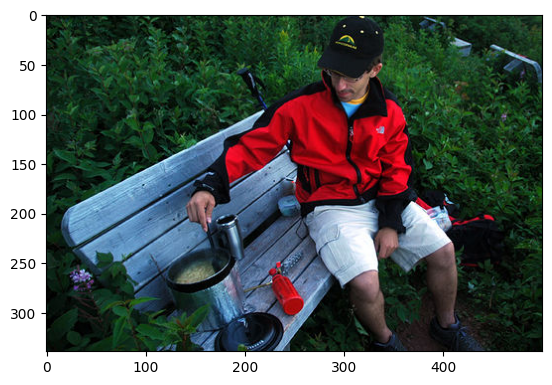

In [ ]:
generate_caption("35506150_cbdb630f4f.jpg")

---------------------Actual---------------------
startseq brown dog is sprayed with water endseq
startseq dog is being squirted with water in the face outdoors endseq
startseq dog stands on his hind feet and catches stream of water endseq
startseq jug is jumping up it is being squirted with jet of water endseq
startseq "a tan male dog is jumping up to get drink of water from spraying bottle ." endseq
--------------------Predicted--------------------
caption: " brown dog is playing with brown dog in the grass endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq


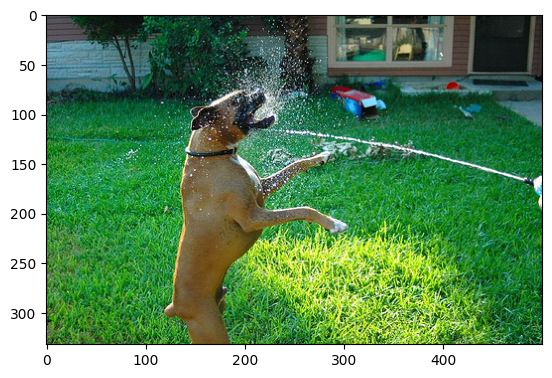

In [ ]:
generate_caption("44856031_0d82c2c7d1.jpg")

---------------------Actual---------------------
startseq boy in yellow is riding scooter on the street endseq
startseq boy on scooter endseq
startseq boy wearing helmet rides scooter in suburban neighborhood endseq
startseq child on scooter is jumping the curb endseq
startseq young boy wearing an orange helmet riding scooter endseq
--------------------Predicted--------------------
caption: " the the man wearing no shirt is riding bike endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq


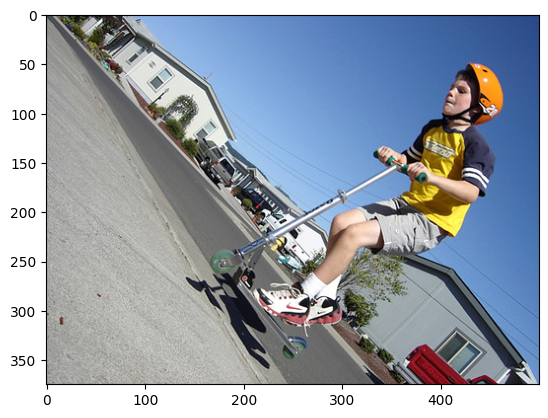

In [ ]:
generate_caption("47870024_73a4481f7d.jpg")